# Многоцелевая модель для NER + event-CLS

Проект объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

## Подготовка данных

Скачаем датасеты NEREL и сохраним их на диск.

In [1]:
import urllib.request
from pathlib import Path

BASE_URL = 'https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/'
FILE_NAMES = ['train.jsonl', 'test.jsonl']
DATA_DIR = Path('data')

DATA_DIR.mkdir(exist_ok=True)
for file_name in FILE_NAMES:
    urllib.request.urlretrieve(BASE_URL + file_name, DATA_DIR / file_name)

Прочитаем дадасеты с диска.

In [2]:
import json

def load_records(path: Path) -> list:
    records = []
    with path.open(encoding='utf-8') as f:
        for line in f:
            record = json.loads(line)
            records.append(record)
    return records

train_records = load_records(DATA_DIR / 'train.jsonl')
test_records = load_records(DATA_DIR / 'test.jsonl')

print(f'Загружено обучающих примеров: {len(train_records)}')
print(f'Загружено тестовых примеров: {len(test_records)}')

Загружено обучающих примеров: 746
Загружено тестовых примеров: 93


Функции для парсинга файлов.

In [3]:
import re

def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}

## EDA

Соберём статистику по длинам текста, количеству сущностей на текст и частотам сущностей и отношений, а затем отобразим
эти данные на графиках.

In [4]:
from collections import Counter

text_lengths = []
n_entities_per_text_list = []
entity_frequencies = Counter()
relation_frequencies = Counter()

for record in train_records:
    text_lengths.append(len(record['text']))
    n_entities_per_text_list.append(len(record['entities']))
    for entity_line in record['entities']:
        entity_data = parse_entity_line(entity_line)
        entity_frequencies[entity_data['type']] += 1
    for relation_line in record['relations']:
        relation_data = parse_relation_line(relation_line)
        relation_frequencies[relation_data['type']] += 1

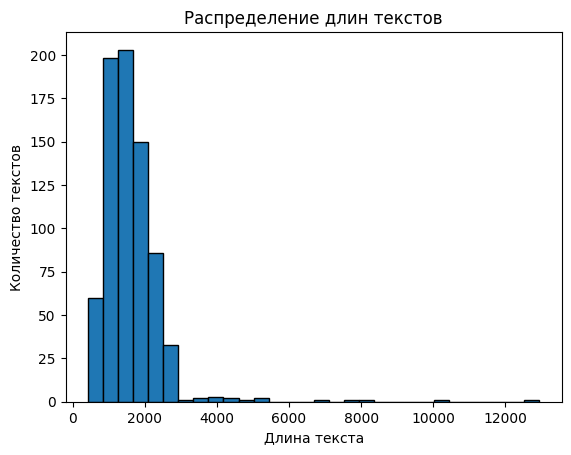

In [5]:
import matplotlib.pyplot as plt

plt.hist(text_lengths, bins=30, edgecolor='black')
plt.title("Распределение длин текстов")
plt.xlabel("Длина текста")
plt.ylabel("Количество текстов");

Подавляющее большинство текстов имеет длину 500-3000 символов.
Также имеются единичные выбросы в виде очень длинных текстов (10,000 символов и больше) — они не поместятся в
контекстное окно модели, и их придётся обрезать.

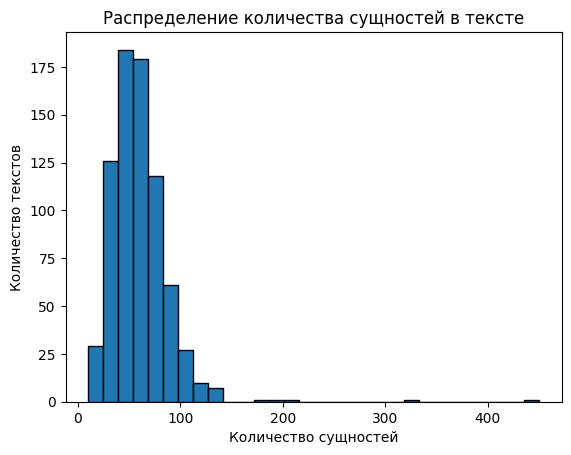

In [6]:
plt.hist(n_entities_per_text_list, bins=30, edgecolor='black')
plt.title('Распределение количества сущностей в тексте')
plt.xlabel('Количество сущностей')
plt.ylabel('Количество текстов');

Большинство текстов имеет от нескольких десяктов до 150 именованных сущностей.

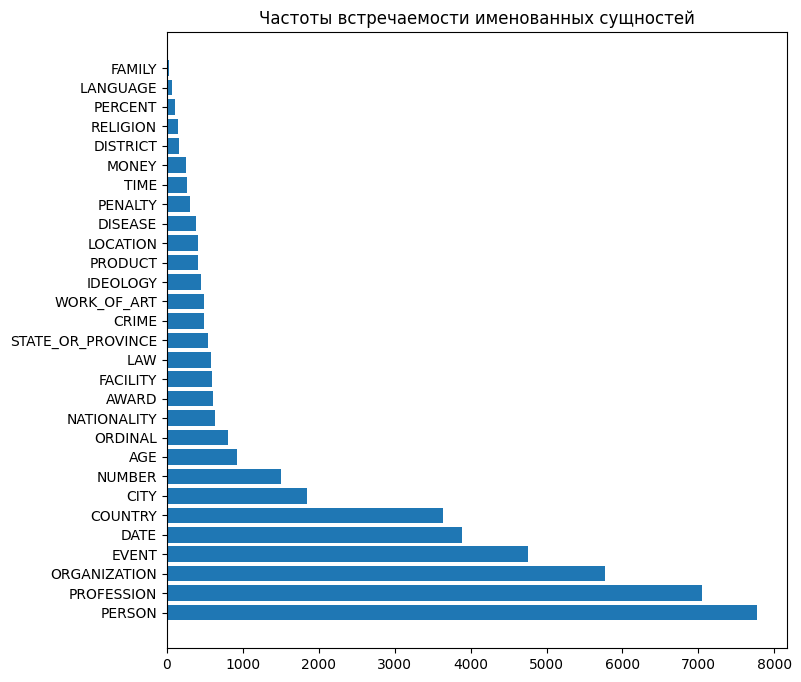

In [7]:
labels, values = zip(*entity_frequencies.most_common(30))
plt.figure(figsize=(8, 8))
plt.barh(labels, values)
plt.title(f'Частоты встречаемости именованных сущностей');

Частоты встречаемости сущностей распределены очень неравномерно, распределение похоже на экспоненциальное.
Следовательно, можно ожидать низкую точность на редких сущностях из-за их нехватки в обучающих примерах.

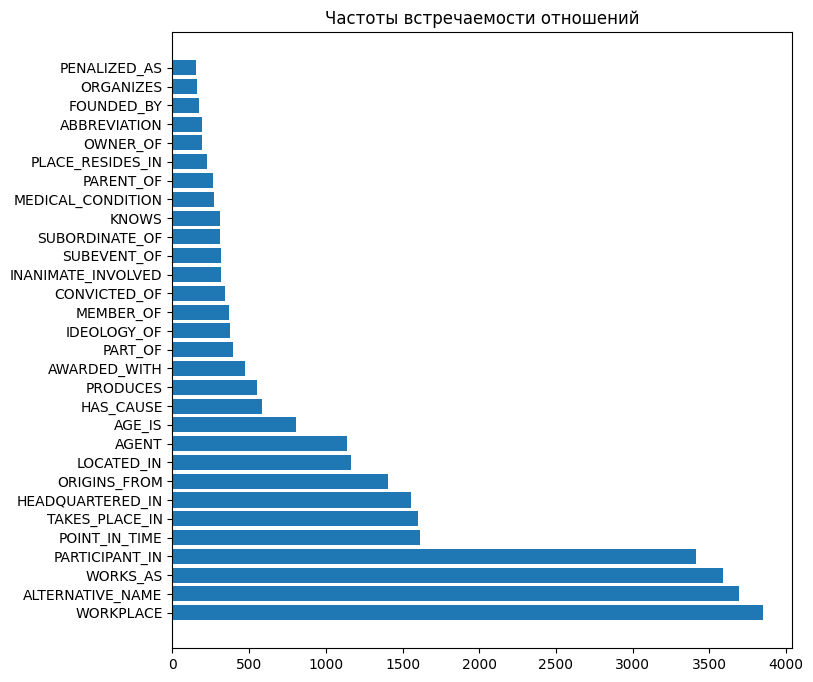

In [8]:
labels, values = zip(*relation_frequencies.most_common(30))
plt.figure(figsize=(8, 8))
plt.barh(labels, values)
plt.title(f'Частоты встречаемости отношений');

Частоты встречаемости отношений тоже распределены очень неравномерно.
Можно ожидать, что для редких классов классификатор будет выдавать заниженные логиты, а для частых — завышенные,
поэтому, если итоговая точность модели окажется неудовлетворительной, можно попробовать использовать эвристику, которая
будет подбирать порог обнаружения класса таким образом, чтобы он был тем выше, чем чаще встречается класс в обучающем
датасете.

## Парсинг и подготовка таргетов

Соберём список всех уникальных отношений в порядке убывания частотности.

In [9]:
all_relations = [x for x, _ in relation_frequencies.most_common()]
all_relations[:3]

['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS']

Реализуем функции для разбиения текста на слова и сопоставления им BIO-меток. Размеченные тексты обернём в `Dataset`.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset, DatasetDict
from tqdm.auto import tqdm

def tokenize_text_by_words(text: str):
    """Разбивает текст по словам."""
    words = []
    spans = []
    for m in re.finditer(r'\S+', text):
        words.append(m.group())
        spans.append((m.start(), m.end()))
    return words, spans

def match_words_to_entities(word_spans: list[tuple[int, int]], entities: list[dict]):
    """Сопоставляет список именованных сущностей со списком слов."""
    word_labels = ['O'] * len(word_spans)
    for entity in entities:
        entry_type = entity['type']
        entity_start = entity['start']
        entity_end = entity['end']
        word_positions = []
        for word_position, (word_start, word_end) in enumerate(word_spans):
            if not (word_end <= entity_start or word_start >= entity_end):
                word_positions.append(word_position)
        if not word_positions:
            continue
        for word_position_in_entity, word_position_in_text in enumerate(word_positions):
            if word_labels[word_position_in_text] != 'O':
                continue
            prefix = 'B' if word_position_in_entity == 0 else 'I'
            word_labels[word_position_in_text] = f'{prefix}-{entry_type}'
    return word_labels

def build_examples_from_nerel(records: list[dict], relations: list[str]):
    """Подготавливает примеры с полностью размеченными данными (токены и отношения)."""
    examples = []
    for record in tqdm(records, desc='Parsing records'):
        text = record['text']
        words, word_spans = tokenize_text_by_words(text)
        entities = list(map(parse_entity_line, record['entities']))
        relation_types = [parse_relation_line(relation)['type'] for relation in record['relations']]
        relation_encoder = MultiLabelBinarizer(classes=relations)
        examples.append(
            {
                'text': text,
                'words': words,
                'word_spans': word_spans,
                'word_labels': match_words_to_entities(word_spans, entities),
                'relation_vector': relation_encoder.fit_transform([relation_types])[0],
            }
        )
    return examples

train_examples = build_examples_from_nerel(train_records, all_relations)
test_examples = build_examples_from_nerel(test_records, all_relations)

full_dataset = DatasetDict(
    {
        'train': Dataset.from_list(train_examples),
        'test': Dataset.from_list(test_examples),
    },
)
full_dataset

Parsing records:   0%|          | 0/746 [00:00<?, ?it/s]

Parsing records:   0%|          | 0/93 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'words', 'word_spans', 'word_labels', 'relation_vector'],
        num_rows: 746
    })
    test: Dataset({
        features: ['text', 'words', 'word_spans', 'word_labels', 'relation_vector'],
        num_rows: 93
    })
})

Зададим правила кодирования и декодирования типов именованных сущностей.

In [11]:
def encode_labels(examples: list[dict]):
    """Собирает все уникальные типы именованных сущностей и присваивает им порядковые номера."""

    unique_labels = {'O'}
    for example in examples:
        unique_labels.update(example['word_labels'])
    label2id = {}
    id2label = {}
    for i, label in enumerate(sorted(unique_labels)):
        label2id[label] = i
        id2label[i] = label
    return label2id, id2label

label2id, id2label = encode_labels(train_examples)

## Токенизация и выравнивание меток

Загрузим токенизатор.

In [12]:
from transformers import AutoTokenizer

MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

Преобразуем датасет, разбив текст на токены с помощью выбранного токенизатора.
При этом сохраним разметку так, чтобы первому токену слова соответствал код метки этого слова, а всем последующим
токенам — специальный код -100.

После этой операции:

* количество токенов в каждом примере станет одинаковым — лишние токены отсекутся, а короткие
  последовательности дополнятся `[PAD]`-ами;

* метки именованных сущностей заменятся на соответствующие им коды.

In [13]:
def tokenize_and_align_labels(examples: list, tokenizer, label2id: dict, max_tokens=512):
    """Разбивает в примерах текст на токены, выравнивая метки именованных сущностей по началу слова."""

    tokenized = tokenizer(
        examples['words'],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=max_tokens,
    )

    label_ids = []
    for batch_index, word_labels in enumerate(examples['word_labels']):
        batch_label_ids = []
        prev_word_id = None
        for word_id in tokenized.word_ids(batch_index):
            if word_id is not None and word_id != prev_word_id:
                label_id = label2id[word_labels[word_id]]
            else:
                label_id = -100
            batch_label_ids.append(label_id)
            prev_word_id = word_id
        label_ids.append(batch_label_ids)

    tokenized['labels'] = label_ids
    return tokenized

tokenized_dataset = full_dataset.map(
    function=tokenize_and_align_labels,
    batched=True,
    fn_kwargs=dict(tokenizer=tokenizer, label2id=label2id),
    remove_columns=['text', 'words', 'word_spans', 'word_labels'],
    desc='Tokenizing dataset',
)
tokenized_dataset

Tokenizing dataset:   0%|          | 0/746 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/93 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['relation_vector', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 746
    })
    test: Dataset({
        features: ['relation_vector', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 93
    })
})

Подготовим `DataLoader`-ы для тренировочного и тестового датасетов.

In [14]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader

data_collator = DataCollatorForTokenClassification(tokenizer)

train_data_loader = DataLoader(
    tokenized_dataset['train'],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

test_data_loader = DataLoader(
    tokenized_dataset['test'],
    batch_size=16,
    collate_fn=data_collator
)

## Модель `JointModel` + custom loss (uncertainty weighting)

Загрузим базовую модель, которую будем использовать в качестве энкодера.

In [15]:
import torch
from transformers import AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

Реализуем многозадачную модель, которая по выходу энкодера будет предсказывать:

1. тип каждого токена (NER);

2. какие отношения содержатся в тексте.

In [16]:
import torch.nn as nn
from dataclasses import dataclass
from datetime import datetime, timedelta
import pandas as pd

@dataclass
class JointModelOutput:
    """Возвращаемый тип метода `JointModel.forward`"""

    token_logits: torch.FloatTensor
    relation_logits: torch.FloatTensor
    loss: pd.Series | None
    execution_time: timedelta

class JointModel(nn.Module):
    """Многозадачная модель, классифицирующая токены для NER и распознающая отношения в тексте."""

    def __init__(self, base_model, num_labels: int, num_relations: int, loss_weights: dict = None, dropout_rate=0.1):
        super().__init__()
        self.base_model = base_model

        if loss_weights is not None:
            # Нормируем и инициализируем веса loss для разных задач.
            token_classification_weight = loss_weights['token_classification']
            relation_recognition_weight = loss_weights['relation_recognition']
            loss_weight_sum = float(token_classification_weight + relation_recognition_weight)
            self.token_classification_weight = token_classification_weight / loss_weight_sum
            self.relation_recognition_weight = relation_recognition_weight / loss_weight_sum
            self.log_sigma_token = self.log_sigma_cls = None
        else:
            # Инициализируем параметры для uncertainty weighting (автоматический подбор весов).
            self.token_classification_log_sigma = nn.Parameter(torch.tensor(0.0))
            self.relation_recognition_log_sigma = nn.Parameter(torch.tensor(0.0))
            self.token_classification_weight = self.relation_recognition_weight = None
    
        self.num_relations = num_relations
        self.num_labels = num_labels

        self.token_classification_dropout = nn.Dropout(dropout_rate)
        self.relation_recognition_dropout = nn.Dropout(dropout_rate)
        self.token_classifier = nn.Linear(base_model.config.hidden_size, num_labels)
        self.relation_classifier = nn.Linear(base_model.config.hidden_size, num_relations)
        self.token_classification_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
        self.relation_recognition_loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None, relation_vector=None, **kwargs):
        start_time = datetime.now()
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        token_logits = self.token_classifier(self.token_classification_dropout(outputs.last_hidden_state))
        relation_logits = self.relation_classifier(self.relation_recognition_dropout(outputs.last_hidden_state[:, 0]))

        # Вычисляем loss.
        if labels is not None and relation_vector is not None:
            token_classification_loss = self.token_classification_loss_fn(
                token_logits.view(-1, self.num_labels), labels.view(-1)
            )
            relation_recognition_loss = self.relation_recognition_loss_fn(relation_logits, relation_vector.float())

            if self.token_classification_weight is not None and self.relation_recognition_weight is not None:
                # Если явно заданы веса, считаем loss как взвешенную сумму.
                total_loss = (
                    self.token_classification_weight * token_classification_loss +
                    self.relation_recognition_weight * relation_recognition_loss
                )
            else:
                # В противном случае считаем loss по формуле для uncertainty weighting.
                token_loss_term = torch.exp(-2.0 * self.token_classification_log_sigma) * \
                    token_classification_loss + self.token_classification_log_sigma
                relation_loss_term = torch.exp(-2.0 * self.relation_recognition_log_sigma) * \
                    relation_recognition_loss + self.relation_recognition_log_sigma
                total_loss = token_loss_term + relation_loss_term
                
            # Собираем общий loss.
            loss = pd.Series(
                {
                    'token_classification': token_classification_loss,
                    'relation_recognition': relation_recognition_loss,
                    'total': total_loss,
                }
            )
        else:
            loss = None

        return JointModelOutput(
            token_logits=token_logits,
            relation_logits=relation_logits,
            loss=loss,
            execution_time=datetime.now() - start_time,
        )

model = JointModel(
    base_model,
    num_labels=len(label2id),
    num_relations=len(all_relations),
    # Раскомментируйте, чтобы использовать фиксированные веса вместо uncertainty weighting:
    # loss_weights={'token_classification': 1, 'relation_recognition': 1},
).to(device)

## Training / Validation

Реализуем функцию, которая будет запускать модель на датасете и выводить подробные результаты инференса в
виде `DataFrame`-ов — по ним будет удобно вычислять точность и анализировать поведение модели, например, находить
примеры, на которых модель ошибается.

In [17]:
import numpy as np

def run_model(model, data_loader, progress_bar=False, on_batch_processed=None):
    """Прогоняет модель на датасете и составляет два DataFrame с данными инференса на задачах NER и поиска отношений."""

    # Переменные-аккумуляторы, будут накапливаться по мере обработки батчей.
    token_df_batches = []
    relation_vector_df_batches = []
    texts_processed = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Running model', unit='batch', disable=not progress_bar):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Записываем размерность батча, чтобы корректно отсчитывать индекс DataFrame-ов.
            n_texts, n_tokens = batch['input_ids'].shape

            output = model(**batch)
            if on_batch_processed is not None:
                on_batch_processed(batch, output)

            # Добавляем DataFrame с предсказаниями типов токенов (разбивка по токенам).
            token_df_batch = pd.DataFrame(
                {
                    'token': tokenizer.batch_decode(batch['input_ids'].view(-1)),  # текст токена
                    'token_id': batch['input_ids'].view(-1).numpy(force=True),  # код токена
                    'pred_label_id': output.token_logits.argmax(dim=-1).view(-1).numpy(force=True),  # ID предсказанного BIO-маркера
                    'text_id': texts_processed + np.repeat(np.arange(n_texts), n_tokens),  # номер текста
                    'token_pos': np.tile(np.arange(n_tokens), n_texts),  # позиция токена в тексте
                }
            )
            if 'labels' in batch:
                token_df_batch['true_label_id'] = batch['labels'].view(-1).numpy(force=True)
            token_df_batches.append(token_df_batch.set_index(['text_id', 'token_pos']))

            # Преобразуем логиты вектора отношений в бинарные метки.
            # Если sigmoind(logit) превышает указанный порог, считаем, что отношение обнаружилось.
            relation_p = torch.sigmoid(output.relation_logits)

            # Добавляем DataFrame с предсказаниями отношений (разбивка по текстам).
            relation_vector_df_batch = pd.DataFrame(
                {
                    'text_preview': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True)[:100],  # текст примера (обрезанный)
                    'pred_vector': list(relation_p.numpy(force=True)),  # multihot-вектор предсказанных отношений в тексте
                    'text_id': texts_processed + np.arange(n_texts),  # номер текста
                }
            )
            if 'relation_vector' in batch:
                relation_vector_df_batch['true_vector'] = list(batch['relation_vector'].numpy(force=True))
            relation_vector_df_batches.append(relation_vector_df_batch.set_index('text_id'))

            texts_processed += n_texts

    # Конкатенируем DataFrame-ы по всем батчам.
    token_df = pd.concat(token_df_batches)
    relation_vector_df = pd.concat(relation_vector_df_batches)

    # Добавляем колонки с названиями меток токенов для наглядности.
    token_df['pred_label'] = token_df.pred_label_id.replace(id2label)
    if 'true_label_id' in token_df:
        token_df['true_label'] = token_df.true_label_id.replace(id2label)

    return token_df, relation_vector_df

token_df, relation_vector_df = run_model(model, test_data_loader, progress_bar=True)

Running model:   0%|          | 0/6 [00:00<?, ?batch/s]

Посмотрим, как выглядит `token_df`.

In [18]:
token_df

token  token_id  pred_label_id  true_label_id  \
text_id token_pos                                                   
0       0           [CLS]       101             20           -100   
        1               С       526              5             16   
        2          ##лова     34017             46           -100   
        3          ##цкий     36643             10           -100   
        4          тренер     31470             16             24   
...                   ...       ...            ...            ...   
92      507         [PAD]         0              3           -100   
        508         [PAD]         0             27           -100   
        509         [PAD]         0             33           -100   
        510         [PAD]         0              3           -100   
        511         [PAD]         0             33           -100   

                      pred_label     true_label  
text_id token_pos                                
0       0              B-PENALTY           -100  
        1                 B-DATE  B-NATIONALITY  
        2              I-ORDINAL           -100  
        3               B-FAMILY           -100  
        4          B-NATIONALITY   B-PROFESSION  
...                          ...            ...  
92      507            B-COUNTRY           -100  
        508               B-TIME           -100  
        509              I-CRIME           -100  
        510            B-COUNTRY           -100  
        511              I-CRIME           -100  

[47616 rows x 6 columns]

Как видим, он не очень удобен для анализа, потому что строки разбиты по субтокенам, а нижняя половина заполнена
`[PAD]`-ами и не несёт никакой полезной информации.
Преобразуем его таким образом, чтобы "склеить" субтокены обратно в слова и убрать строки со служебными токенами.

In [19]:
def build_word_df(token_df: pd.DataFrame, drop_token_ids=None, progress_bar=False):
    accumulated_rows = []
    for _, row in tqdm(
        token_df.reset_index().iterrows(),
        total=len(token_df),
        desc='Reconstructing words',
        disable=not progress_bar,
    ):
        if row.token.startswith('##'):
            accumulated_rows[-1].token += row.token[2:]  # приклеиваем кусок слова, убирая "##"" в начале
        else:
            accumulated_rows.append(row)
    word_df = pd.DataFrame(accumulated_rows)
    if 'true_label_id' in word_df:
        word_df.query('true_label_id != -100', inplace=True)
    if drop_token_ids is not None:
        word_df = word_df[~word_df.token_id.isin(drop_token_ids)]
    return word_df.drop(columns='token_id').set_index(['text_id', 'token_pos'])

word_df = build_word_df(token_df, progress_bar=True)
word_df

Reconstructing words:   0%|          | 0/47616 [00:00<?, ?it/s]

token  pred_label_id  true_label_id     pred_label  \
text_id token_pos                                                           
0       1          Словацкий              5             16         B-DATE   
        4             тренер             16             24  B-NATIONALITY   
        5               Жолт             45             22       I-NUMBER   
        8             Хорняк             30             50        I-AWARD   
        12         возглавил             18              8      B-ORDINAL   
...                      ...            ...            ...            ...   
92      409                к             32             56      I-COUNTRY   
        410            этому             18             56      B-ORDINAL   
        411            посту              1             56        B-AWARD   
        413           Прощай              5             56         B-DATE   
        417           Эдичка             41             22          I-LAW   

                      true_label  
text_id token_pos                 
0       1          B-NATIONALITY  
        4           B-PROFESSION  
        5               B-PERSON  
        8               I-PERSON  
        12               B-EVENT  
...                          ...  
92      409                    O  
        410                    O  
        411                    O  
        413                    O  
        417             B-PERSON  

[18281 rows x 5 columns]

Совсем другое дело! Можно видеть, что `true_label` соответствует смыслу `token`, а `pred_label` выглядит хаотично — это
ожидаемо, поскольку модель еще не обучалась на downstream-задаче. Также заметим, что поскольку все служебные токены были удалены, для оценки точности модели на NER-задаче достаточно
сравнить колонки `true_label_id` и `pred_label_id`.

Теперь рассмотрим `relation_vector_df`.

In [20]:
relation_vector_df

,text_preview,pred_vector,true_vector
text_id,,,
0,"Словацкий тренер Жолт Хорняк возглавил "" Банан...","[0.47205436, 0.5258061, 0.56842834, 0.45556322...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, ..."
1,Глава департамента ЦБ РФ Надежда Иванова получ...,"[0.5112579, 0.49495363, 0.5329669, 0.47830895,...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ..."
2,Умер самый старый миллиардер в мире Дэвид Рокф...,"[0.55053663, 0.52783954, 0.55284274, 0.4885454...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,"Медалью ордена "" За заслуги перед Чувашской Ре...","[0.47149193, 0.5231876, 0.54927534, 0.45840153...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ..."
4,Depeche Mode выпустил новый альбом Spirit Выст...,"[0.5041666, 0.51138216, 0.59519315, 0.5048238,...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, ..."
...,...,...,...
88,Замминистра здравоохранения Великобритании зар...,"[0.46532637, 0.53556967, 0.5488876, 0.5017065,...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
89,Умер создатель индастриала Дженезис Пи - Оррид...,"[0.522178, 0.5426287, 0.61249375, 0.49230352, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ..."
90,Билл Гейтс покинул совет директоров Microsoft ...,"[0.5029149, 0.5086805, 0.5824445, 0.4704195, 0...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ..."


Как видим, он тоже неудобен для анализа, потому что векторы не несут никакой наглядной информации и даже не влезают в
ячейки.
Преобразуем его таким образом, чтобы векторы были развёрнуты по строками и в каждой строке было название отношения,
которое кодируется координатой вектора.

In [21]:
def build_relation_df(relation_vector_df: pd.DataFrame):
    column_mapping = {'pred_vector': 'pred'}
    if 'true_vector' in relation_vector_df:
        column_mapping['true_vector'] = 'true'
    v_columns = list(column_mapping)
    relation_df = relation_vector_df[v_columns].explode(v_columns).rename(columns=column_mapping)
    relation_df['relation'] = all_relations * len(relation_vector_df)
    if 'true' in relation_df:
        relation_df['true'] = relation_df.true.astype('i8')
    relation_df.insert(0, 'text_preview', relation_vector_df.text_preview)
    return relation_df.set_index('relation', append=True)

relation_df = build_relation_df(relation_vector_df)
relation_df

text_preview  \
text_id relation                                                              
0       WORKPLACE         Словацкий тренер Жолт Хорняк возглавил " Банан...   
        ALTERNATIVE_NAME  Словацкий тренер Жолт Хорняк возглавил " Банан...   
        WORKS_AS          Словацкий тренер Жолт Хорняк возглавил " Банан...   
        PARTICIPANT_IN    Словацкий тренер Жолт Хорняк возглавил " Банан...   
        POINT_IN_TIME     Словацкий тренер Жолт Хорняк возглавил " Банан...   
...                                                                     ...   
92      DATE_FOUNDED_IN   Умер Эдуард Лимонов Эдуард Лимонов Во вторник,...   
        RELATIVE          Умер Эдуард Лимонов Эдуард Лимонов Во вторник,...   
        EXPENDITURE       Умер Эдуард Лимонов Эдуард Лимонов Во вторник,...   
        END_TIME          Умер Эдуард Лимонов Эдуард Лимонов Во вторник,...   
        DATE_DEFUNCT_IN   Умер Эдуард Лимонов Эдуард Лимонов Во вторник,...   

                              pred  true  
text_id relation                          
0       WORKPLACE         0.472054     1  
        ALTERNATIVE_NAME  0.525806     1  
        WORKS_AS          0.568428     1  
        PARTICIPANT_IN    0.455563     1  
        POINT_IN_TIME     0.468321     0  
...                            ...   ...  
92      DATE_FOUNDED_IN   0.548487     0  
        RELATIVE          0.492506     0  
        EXPENDITURE       0.459454     0  
        END_TIME          0.438254     0  
        DATE_DEFUNCT_IN   0.446582     0  

[4557 rows x 3 columns]

Такой `DataFrame` удобно анализировать, а для оценки точности модели на задаче поиска отношений достаточно сравнить
колонки `true` и `pred`.

Теперь реализуем функцию, которая будет вычислять точность модели по двум приведённым выше `DataFrame`-ам.
Поскольку для каждой задачи (NER и поиск отношений) мы будем рассчитывать точность отдельно, а метрик может быть несколько
(recall, precision, f1), для описания точности модели также будет удобно использовать `DataFrame`.

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Название метрики / функция для расчёта / дополнительные kw-аргументы функции.
SCORERS = [
    ('precision', precision_score, dict(average='macro', zero_division=0)),
    ('recall',    recall_score,    dict(average='macro', zero_division=0)),
    ('f1',        f1_score,        dict(average='macro', zero_division=0)),
    ('f1_micro',  f1_score,        dict(average='micro', zero_division=0))
]

def calculate_scores(word_df: pd.DataFrame, relation_df: pd.DataFrame, scorers: dict, relation_p_threshold=0.5):
    scores = {}
    binarized_relations = (relation_df.pred >= relation_p_threshold)
    for metric, scorer, scorer_kwargs in scorers:
        scores[metric] = (
            {
                'token_classification': scorer(word_df.true_label_id, word_df.pred_label_id, **scorer_kwargs),
                'relation_recognition': scorer(relation_df.true, binarized_relations, **scorer_kwargs),
            }
        )
    return pd.DataFrame(scores)

calculate_scores(word_df, relation_df, SCORERS)

,precision,recall,f1,f1_micro
token_classification,0.017231,0.012414,0.007535,0.014277
relation_recognition,0.539595,0.546978,0.533125,0.574281


Как видим, по всем метрикам точность необученной модели на NER очень мала (порядка одного процента), а точность
распознавания отношений близка к 0.5, что соответствует выбору наугад.

Далее мы будем исследовать, как меняется точность модели в процессе обучения, но сначала реализуем вспомогательную
функцию, которая будет выполнять все предыдущие этапы — от тестирования модели и генерации `DataFrame`-ов до расчёта
точности.

In [23]:
def score_model(model, data_loader, scorers, progress_bar=False):
    model.eval()
    token_df, relation_vector_df = run_model(model, data_loader, progress_bar=progress_bar)
    word_df = build_word_df(token_df, progress_bar=progress_bar)
    relation_df = build_relation_df(relation_vector_df)
    score_df = calculate_scores(word_df, relation_df, scorers)
    return word_df, relation_df, score_df

Наконец, реализуем цикл обучения модели и запустим его с одной эпохой, чтобы проверить, растёт ли точность
в процессе обучения.

In [24]:
LOSS_KEYS = ['token_classification', 'relation_recognition', 'total']

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

def train_model(model, data_loader, optimizer, n_epochs, scorers, last_epoch=0):
    for epoch in range(n_epochs):
        model.train()
        accumulated_loss = pd.Series(index=LOSS_KEYS).fillna(0)
        log_prefix = f'Epoch {epoch + last_epoch + 1}'
        n_batches_processed = 0
        for batch in tqdm(data_loader, desc=log_prefix, unit='batch', leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.total.backward()
            optimizer.step()
            optimizer.zero_grad()
            accumulated_loss += loss
            n_batches_processed += 1
        average_loss = accumulated_loss / n_batches_processed
        print(f'{log_prefix}: ' + ', '.join(f'{key}_loss={average_loss[key]:.4f}' for key in LOSS_KEYS))
        _, _, score_df = score_model(model, test_data_loader, scorers)
        yield {'loss': average_loss, 'score_df': score_df}

epoch_log = []
for epoch_data in train_model(
    model=model,
    data_loader=train_data_loader,
    optimizer=optimizer,
    n_epochs=1,
    scorers=SCORERS,
):
    epoch_log.append(epoch_data)

epoch_log[-1]['score_df']

Epoch 1:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 1: token_classification_loss=1.6323, relation_recognition_loss=0.5346, total_loss=2.1659


,precision,recall,f1,f1_micro
token_classification,0.166208,0.180160,0.168249,0.795799
relation_recognition,0.798730,0.753489,0.770164,0.825104


Как видим, точность модели действительно выросла, а значит, она успешно обучается.

Теперь дообучим модель на большем количестве эпох, чтобы достигнуть требуемых критериев точности:
* `score_df.loc['token_classification', 'f1'] >= 0.5`
* `score_df.loc['relation_recognition', 'f1_micro'] >= 0.8`

In [25]:
# Этот блок можно запускать много раз, чтобы дообучать модель.
# Лог обучения при этом сохраняется.

for epoch_data in train_model(
    model=model,
    data_loader=train_data_loader,
    optimizer=optimizer,
    n_epochs=50,
    scorers=SCORERS,
    last_epoch=len(epoch_log),
):
    epoch_log.append(epoch_data)

epoch_log[-1]['score_df']

Epoch 2:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 2: token_classification_loss=0.7084, relation_recognition_loss=0.4107, total_loss=1.1186


Epoch 3:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 3: token_classification_loss=0.4630, relation_recognition_loss=0.3839, total_loss=0.8467


Epoch 4:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 4: token_classification_loss=0.3476, relation_recognition_loss=0.3639, total_loss=0.7110


Epoch 5:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 5: token_classification_loss=0.2749, relation_recognition_loss=0.3483, total_loss=0.6222


Epoch 6:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 6: token_classification_loss=0.2241, relation_recognition_loss=0.3342, total_loss=0.5564


Epoch 7:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 7: token_classification_loss=0.1852, relation_recognition_loss=0.3191, total_loss=0.5010


Epoch 8:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 8: token_classification_loss=0.1597, relation_recognition_loss=0.3090, total_loss=0.4641


Epoch 9:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 9: token_classification_loss=0.1372, relation_recognition_loss=0.2974, total_loss=0.4282


Epoch 10:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 10: token_classification_loss=0.1170, relation_recognition_loss=0.2877, total_loss=0.3964


Epoch 11:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 11: token_classification_loss=0.1022, relation_recognition_loss=0.2767, total_loss=0.3683


Epoch 12:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 12: token_classification_loss=0.0894, relation_recognition_loss=0.2668, total_loss=0.3433


Epoch 13:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 13: token_classification_loss=0.0785, relation_recognition_loss=0.2585, total_loss=0.3218


Epoch 14:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 14: token_classification_loss=0.0688, relation_recognition_loss=0.2476, total_loss=0.2987


Epoch 15:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 15: token_classification_loss=0.0613, relation_recognition_loss=0.2394, total_loss=0.2803


Epoch 16:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 16: token_classification_loss=0.0539, relation_recognition_loss=0.2285, total_loss=0.2592


Epoch 17:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 17: token_classification_loss=0.0499, relation_recognition_loss=0.2207, total_loss=0.2446


Epoch 18:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 18: token_classification_loss=0.0428, relation_recognition_loss=0.2132, total_loss=0.2272


Epoch 19:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 19: token_classification_loss=0.0406, relation_recognition_loss=0.2052, total_loss=0.2140


Epoch 20:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 20: token_classification_loss=0.0373, relation_recognition_loss=0.1991, total_loss=0.2017


Epoch 21:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 21: token_classification_loss=0.0351, relation_recognition_loss=0.1909, total_loss=0.1882


Epoch 22:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 22: token_classification_loss=0.0299, relation_recognition_loss=0.1827, total_loss=0.1717


Epoch 23:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 23: token_classification_loss=0.0284, relation_recognition_loss=0.1743, total_loss=0.1585


Epoch 24:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 24: token_classification_loss=0.0247, relation_recognition_loss=0.1666, total_loss=0.1438


Epoch 25:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 25: token_classification_loss=0.0241, relation_recognition_loss=0.1601, total_loss=0.1336


Epoch 26:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 26: token_classification_loss=0.0224, relation_recognition_loss=0.1535, total_loss=0.1221


Epoch 27:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 27: token_classification_loss=0.0204, relation_recognition_loss=0.1464, total_loss=0.1096


Epoch 28:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 28: token_classification_loss=0.0189, relation_recognition_loss=0.1406, total_loss=0.0989


Epoch 29:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 29: token_classification_loss=0.0167, relation_recognition_loss=0.1339, total_loss=0.0865


Epoch 30:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 30: token_classification_loss=0.0165, relation_recognition_loss=0.1283, total_loss=0.0775


Epoch 31:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 31: token_classification_loss=0.0155, relation_recognition_loss=0.1232, total_loss=0.0681


Epoch 32:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 32: token_classification_loss=0.0145, relation_recognition_loss=0.1195, total_loss=0.0601


Epoch 33:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 33: token_classification_loss=0.0145, relation_recognition_loss=0.1129, total_loss=0.0501


Epoch 34:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 34: token_classification_loss=0.0128, relation_recognition_loss=0.1093, total_loss=0.0414


Epoch 35:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 35: token_classification_loss=0.0120, relation_recognition_loss=0.1041, total_loss=0.0320


Epoch 36:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 36: token_classification_loss=0.0120, relation_recognition_loss=0.0997, total_loss=0.0243


Epoch 37:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 37: token_classification_loss=0.0121, relation_recognition_loss=0.0959, total_loss=0.0173


Epoch 38:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 38: token_classification_loss=0.0107, relation_recognition_loss=0.0924, total_loss=0.0090


Epoch 39:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 39: token_classification_loss=0.0115, relation_recognition_loss=0.0885, total_loss=0.0026


Epoch 40:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 40: token_classification_loss=0.0112, relation_recognition_loss=0.0845, total_loss=-0.0050


Epoch 41:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 41: token_classification_loss=0.0099, relation_recognition_loss=0.0818, total_loss=-0.0124


Epoch 42:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 42: token_classification_loss=0.0096, relation_recognition_loss=0.0786, total_loss=-0.0193


Epoch 43:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 43: token_classification_loss=0.0095, relation_recognition_loss=0.0765, total_loss=-0.0246


Epoch 44:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 44: token_classification_loss=0.0093, relation_recognition_loss=0.0737, total_loss=-0.0309


Epoch 45:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 45: token_classification_loss=0.0092, relation_recognition_loss=0.0710, total_loss=-0.0370


Epoch 46:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 46: token_classification_loss=0.0079, relation_recognition_loss=0.0684, total_loss=-0.0442


Epoch 47:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 47: token_classification_loss=0.0080, relation_recognition_loss=0.0651, total_loss=-0.0508


Epoch 48:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 48: token_classification_loss=0.0084, relation_recognition_loss=0.0640, total_loss=-0.0545


Epoch 49:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 49: token_classification_loss=0.0074, relation_recognition_loss=0.0614, total_loss=-0.0615


Epoch 50:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 50: token_classification_loss=0.0085, relation_recognition_loss=0.0597, total_loss=-0.0651


Epoch 51:   0%|          | 0/47 [00:00<?, ?batch/s]

Epoch 51: token_classification_loss=0.0069, relation_recognition_loss=0.0568, total_loss=-0.0732


,precision,recall,f1,f1_micro
token_classification,0.746013,0.714651,0.717475,0.902248
relation_recognition,0.856237,0.839689,0.847286,0.877770


Теперь точность модели достигла необходимого порога.

Проследим, как меняются loss и точность, построив графики по эпохам.

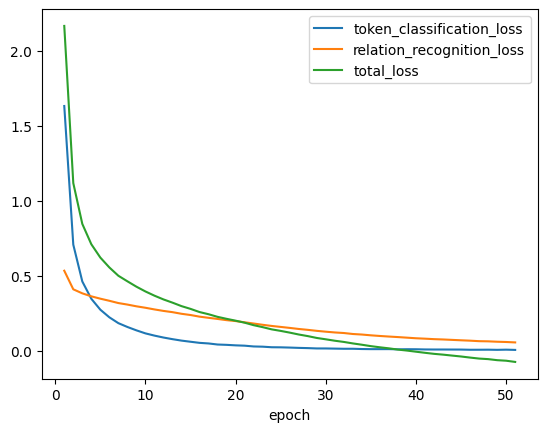

In [26]:
learning_data = []
for epoch_data in epoch_log:
    loss = epoch_data['loss']
    score_df = epoch_data['score_df']
    learning_data.append(
        {
            'token_classification_loss': loss.token_classification.numpy(force=True),
            'relation_recognition_loss': loss.relation_recognition.numpy(force=True),
            'total_loss': loss.total.numpy(force=True),
            'token_classification_f1': score_df.loc['token_classification', 'f1'],
            'relation_recognition_f1_micro': score_df.loc[ 'relation_recognition', 'f1_micro'],
        }
    )
learning_df = pd.DataFrame(
    data=learning_data,
    index=pd.RangeIndex(len(learning_data), name='epoch') + 1,
).astype(float)

learning_df.filter(like='loss').plot();

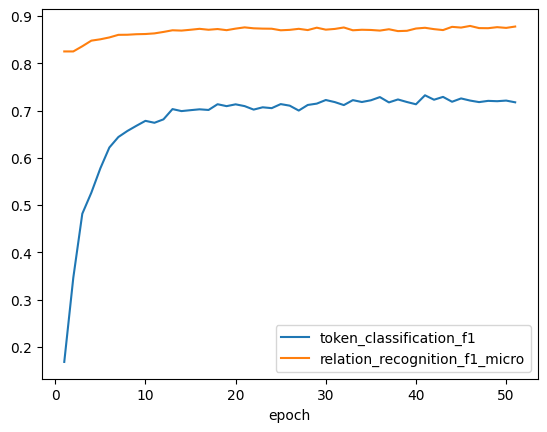

In [27]:
learning_df.filter(like='f1').plot();

## Инференс, квантизация и анализ ошибок

Теперь, когда модель обучена, реализуем end-to-end пайплайн, который будет принимать сырой текст и выдавать распознанные
сущности и отношения.

In [28]:
def classify_tokens_and_recognize_relations(texts: list[str], model, max_tokens=512):
    tokenized_texts = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_tokens,
        return_tensors='pt',
    )
    tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}
    dataset = Dataset.from_dict(tokenized_texts)
    data_loader = DataLoader(
        dataset,
        batch_size=16,
        collate_fn=data_collator
    )
    token_df, relation_vector_df = run_model(model, data_loader)
    word_df = build_word_df(token_df, drop_token_ids=tokenizer.all_special_ids)
    relation_df = build_relation_df(relation_vector_df)
    return word_df, relation_df

texts = [
    'Александр Сергеевич Пушкин родился в Москве в 1799 году',
    'Иван работает строителем',
]
word_df, relation_df = classify_tokens_and_recognize_relations(texts, model)

Проверим, как модель расставила BIO-метки.

In [29]:
word_df

token  pred_label_id    pred_label
text_id token_pos                                         
0       1           Александр             22      B-PERSON
        2           Сергеевич             50      I-PERSON
        3              Пушкин             50      I-PERSON
        5             родился              8       B-EVENT
        6                   в             56             O
        7              Москве              2        B-CITY
        8                   в              5        B-DATE
        9                1799             34        I-DATE
        10               году             34        I-DATE
1       1                Иван             22      B-PERSON
        2            работает             56             O
        3          строителем             24  B-PROFESSION

Посмотрим топ-5 самых вероятных отношений.

In [30]:
(
    relation_df
    .sort_values('pred', ascending=False)
    .groupby('text_id')
    .head(5)
    .sort_values(['text_id', 'pred'], ascending=[True, False])
)

text_preview  \
text_id relation                                                              
0       DATE_OF_BIRTH     Александр Сергеевич Пушкин родился в Москве в ...   
        PARTICIPANT_IN    Александр Сергеевич Пушкин родился в Москве в ...   
        TAKES_PLACE_IN    Александр Сергеевич Пушкин родился в Москве в ...   
        PLACE_OF_BIRTH    Александр Сергеевич Пушкин родился в Москве в ...   
        PRODUCES          Александр Сергеевич Пушкин родился в Москве в ...   
1       WORKS_AS                                   Иван работает строителем   
        ALTERNATIVE_NAME                           Иван работает строителем   
        PARENT_OF                                  Иван работает строителем   
        PARTICIPANT_IN                             Иван работает строителем   
        WORKPLACE                                  Иван работает строителем   

                              pred  
text_id relation                    
0       DATE_OF_BIRTH     0.961693  
        PARTICIPANT_IN     0.94188  
        TAKES_PLACE_IN    0.913774  
        PLACE_OF_BIRTH    0.903011  
        PRODUCES           0.89144  
1       WORKS_AS          0.881959  
        ALTERNATIVE_NAME  0.877186  
        PARENT_OF         0.805597  
        PARTICIPANT_IN    0.685184  
        WORKPLACE          0.52458

Чтобы лучше понять, в каких случаях модель ошибается, вернёмся к тестовому датасету.

In [31]:
token_df, relation_vector_df = run_model(model, test_data_loader, progress_bar=True)
word_df = build_word_df(token_df)
relation_df = build_relation_df(relation_vector_df)

Running model:   0%|          | 0/6 [00:00<?, ?batch/s]

Выведем выборку из 20 ошибочных предсказаний типа сущности.

In [32]:
# Можно запустить несколько раз, чтобы посмотреть разные выборки.
word_df.query('pred_label != true_label').sample(20)

,,token,pred_label_id,true_label_id,pred_label,true_label
text_id,token_pos,,,,,
51,76,фильма,56,37,O,I-EVENT
92,312,заключил,8,56,B-EVENT,O
72,97,центре,38,56,I-FACILITY,O
9,165,отречения,8,37,B-EVENT,I-EVENT
36,76,борьбу,4,56,B-CRIME,O
43,200,саке,37,56,I-EVENT,O
22,201,13,18,13,B-ORDINAL,B-LAW
15,263,силовики,52,24,I-PROFESSION,B-PROFESSION
76,134,выступления,56,8,O,B-EVENT


Проанализоровав несколько таких выборок, можно сделать вывод, что большинство ошибок сводится к двум причинам:
1. некорректно определяются границы сущности (например, `B-ORGANIZATION` вместо `I-ORGANIZATION`), особенно в тех
   местах, где разные сущности пересекаются;
2. путаются близкие по смыслу сущности (например, `NATIONALITY`/`COUNTRY` или `DATE`/`TIME`).

Чтобы уменьшить количество таких ошибок, можно дообучить модель на большем количестве эпох, поэксперементировать с
гиперпараметрами, такими как `dropout_rate`, или увеличить массив обучающих данных.

Теперь рассмотрим выборку неправильно определённых отношений.

In [33]:
# Можно запустить несколько раз, чтобы посмотреть разные выборки.
relation_df.query('(pred >= 0.5) != true').sample(20)

,,text_preview,pred,true
text_id,relation,,,
5,SUBORDINATE_OF,Скончался Евгений Евтушенко Евгений Евтушенко ...,0.062218,1
88,POINT_IN_TIME,Замминистра здравоохранения Великобритании зар...,0.806387,0
86,INANIMATE_INVOLVED,Умер бывший глава ООН Хавьер Перес де Куэльяр ...,0.112513,1
4,AGENT,Depeche Mode выпустил новый альбом Spirit Выст...,0.381937,1
40,OWNER_OF,У Турции есть записи убийства журналиста в сау...,0.019573,1
58,EXPENDITURE,Китайскую компанию наказали за японскую порноа...,0.214421,1
78,DATE_OF_CREATION,Умер Кирк Дуглас последний представитель « зол...,0.460424,1
89,PRODUCES,Умер создатель индастриала Дженезис Пи - Оррид...,0.685698,0
52,ORGANIZES,Герои - школьники из Свердловской области нагр...,0.147599,1


Отследить какие-либо закономерности в данном случае затруднительно.

* `true` принимает значения 0 и 1 с примерно равной частотой, так что нельзя сказать, что в предсказаниях модели
  преобладают false negatives или false positives.

* `pred` принимает самые разные значения из диапазона [0, 1], так что нельзя сказать, что модель ошибается только в тех
  случаях, когда неуверена.

Попытаемся отследить, как длина текста и частота встречаемости отношения влияют на правильность предсказания.
Для этого добавим в таблицу эти параметры и вычислим их средние значения для правильных и неправильных предсказаний.

In [34]:
text_series = pd.Series(full_dataset['test']['text'], name='text').rename_axis(index='text_id')
relation_frequency_series = pd.Series(relation_frequencies, name='relation_frequency').rename_axis(index='relation')
augmented_relation_df = relation_df.join(text_series).join(relation_frequency_series)
augmented_relation_df['text_length'] = augmented_relation_df.text.map(len)
augmented_relation_df['is_true_pred'] = augmented_relation_df.eval('(pred >= 0.5) == true').astype('i8')
augmented_relation_df.groupby(['is_true_pred']).agg({'text_length': 'mean', 'relation_frequency': 'mean'})

,text_length,relation_frequency
is_true_pred,,
0,1769.570916,775.236984
1,1677.854000,620.168500


Как видно из таблицы, длина текста и частотность отношения тоже не оказывают заметного влияния на правильность
предсказания.
Остаётся сделать вывод, что неправильные ответы являются следствием самой архитектуры модели в сочетании со сложностью
задачи.
Возможные пути решения — опробовать модель большего размера или отсечь редкие классы, чтобы сократить размерность
вектора.

Наконец, замерим, сколько времени занимает инференс модели.
Затем создадим quantized-версию модели и сравним её время инференса с оригинальной версией.

Время будет замеряться с помощью специального callback-а, поэтому весь overhead, связанный с обработкой `DataFrame`-ов и
прочими вспомогательными операциями, не будет учитываться.
Все замеры будем проводить на CPU.

In [35]:
old_device = device
device = 'cpu'

def benchmark_inference(model, data_loader, n_tests, desc):
    execution_time = timedelta()

    def on_batch_processed(batch, output):
        nonlocal execution_time
        execution_time += output.execution_time

    for _ in tqdm(range(n_tests), total=n_tests, desc=desc, unit='test', leave=False):
        run_model(model, data_loader, on_batch_processed=on_batch_processed)
    return execution_time / n_tests

quantized_model = torch.quantization.quantize_dynamic(model.to('cpu'), {torch.nn.Linear}, dtype=torch.qint8)

basic_inference_time = benchmark_inference(
    model=model.to(device),
    data_loader=test_data_loader,
    n_tests=10,
    desc='Benchmarking basic model',
)
print(f'Basic model inference time: {basic_inference_time.total_seconds():.4f}')

quantized_inference_time = benchmark_inference(
    model=quantized_model.to(device),
    data_loader=test_data_loader,
    n_tests=10,
    desc='Benchmarking quantized model',
)
print(f'Quantized model inference time: {quantized_inference_time.total_seconds():.4f}')


Benchmarking basic model:   0%|          | 0/10 [00:00<?, ?test/s]

Basic model inference time: 26.2558


Benchmarking quantized model:   0%|          | 0/10 [00:00<?, ?test/s]

Quantized model inference time: 17.5563


Сравним точность обычной и quantized=моделей.

In [36]:
_, _, basic_score_df = score_model(model, test_data_loader, SCORERS, progress_bar=True)
_, _, quantized_score_df = score_model(quantized_model, test_data_loader, SCORERS, progress_bar=True)
score_df = pd.concat([basic_score_df, quantized_score_df], names=['model'], keys=['basic', 'quantized'])
score_df

Running model:   0%|          | 0/6 [00:00<?, ?batch/s]

Reconstructing words:   0%|          | 0/47616 [00:00<?, ?it/s]

Running model:   0%|          | 0/6 [00:00<?, ?batch/s]

Reconstructing words:   0%|          | 0/47616 [00:00<?, ?it/s]

precision    recall        f1  f1_micro
model                                                                  
basic     token_classification   0.746013  0.714651  0.717475  0.902248
          relation_recognition   0.856237  0.839689  0.847286  0.877770
quantized token_classification   0.702878  0.672531  0.675087  0.895793
          relation_recognition   0.847935  0.829136  0.837640  0.870529

Перключим `device` на исходный.

In [37]:
device = old_device

Очистим память (при необходимости).

In [39]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Вывод

* Многозадачная модель была успешно реализована, обучена и протестирована на подготовленных данных.
* Она показала достаточно хорошие результаты как на NER-задаче (f1 > 0.7), так и на задаче поиска отношений в тексте
  (f1_micro > 0.8).
* Ошибки, допущенные моделью, были проанализированы, и были предложены возможные пути их устранения.
* Был реализован end-to-end пайплайн, позволяющий использовать обученную модель на неподготовленных текстах.
* Квантизация модели показала заметный прирост скорости инференса (примерно в 1.5 раза) и почти не сказалась на
  точности.